# Clustering samples by environmental and functional data

The aim here is to cluster samples both by their measured environmental data and the functional metaomics data in order to identify sample groups to be used for statistical analyses.

In [2]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os
from sklearn import cluster
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage,dendrogram,leaves_list,fcluster

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

## Functionality

In [3]:
def standardize(df):
    ts_stand = (df - df.mean()) / df.std()
    return ts_stand

In [4]:
def paired_dendrograms(meta,fun,combined=pd.DataFrame(),metric="correlation",method="complete",wspace=0.75,x=8,y=4,color_threshold=None, t=1):
    if color_threshold:
        if type(color_threshold)==int or type(color_threshold)==float: color_threshold = [color_threshold]*3
    else:
        color_threshold = [None,None,None]
    if combined.empty: fig,axes = plt.subplots(ncols=2,nrows=1)
    else: fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(x,y))
    
    meta_dist = pdist(meta,metric=metric)
    meta_Z = linkage(meta_dist,method=method,metric=metric)
    
    fun_dist = pdist(fun,metric=metric)
    fun_Z = linkage(fun_dist,method=method,metric=metric)
    fun_g = pd.DataFrame(fcluster(fun_Z,criterion="distance",t=t),index=fun.index).to_dict()[0]
    fun_labels = [x+" ("+str(fun_g[x])+")" for x in fun.index]
    
    if not combined.empty: com_dist = pdist(combined,metric=metric)
    
    dendrogram(meta_Z,labels=meta.index,ax=axes[0],orientation="left", color_threshold=color_threshold[0]);
    axes[0].set_title("Metadata")
    
    dendrogram(linkage(fun_dist,method=method,metric=metric),labels=fun_labels,ax=axes[1],orientation="right", color_threshold=color_threshold[1]);
    axes[1].set_title("Functional")
    if not combined.empty: 
        dendrogram(linkage(com_dist,method=method,metric=metric),labels=combined.index,ax=axes[2],orientation="right", color_threshold=color_threshold[2]);
        axes[2].set_title("Combined")
    fig.subplots_adjust(wspace=wspace)

In [5]:
def dist_dataframe(df,metric="correlation"):
    dist = pdist(df,metric=metric)
    return pd.DataFrame(squareform(dist),columns=df.index, index=df.index)

In [6]:
def plot_env_groupings(f,e,metric,method,threshold,order=False):
    d = pdist(f,metric=metric)
    Z = linkage(d,method=method)
    g = pd.DataFrame(fcluster(Z,criterion="distance",t=threshold),index=f.index).to_dict()[0]
    e["Sample"] = e.index
    e["Group"] = [g[x] for x in e.index]
    em = pd.melt(e,id_vars=["Sample","Group"])
    if order: x_order = order
    else: x_order = sorted(set(g.values()))
    ax = sns.factorplot(data=em, col="variable", col_wrap=3, x="Group", order=x_order, 
                    y="value",errwidth=0.5,sharey=False,sharex=False,scale=0.5, size=2, aspect=1.5)
    ax.set_titles("{col_name}");
    for a in ax.axes: a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8);
    ax.fig.subplots_adjust(wspace=.15, hspace=1)
    return g

## Load the data

### Load the environmental data.

In [21]:
metadata = pd.read_csv("data/LMO.time.series.metadata.csv", header=0, sep="\t", index_col=0)
metadata.rename(index=lambda x: str(x)[2:], inplace=True)
metavars = ["Temperature","Chla","Phosphate","Nitrate","Silicate","Ammonium"]

### Load the metaomic data

This data has been processed using the [process_data](process_data.ipynb) notebook.

In [37]:
mg_select_trans = pd.read_table("results/mg/select_trans.tpm.tsv", header=0, sep="\t", index_col=0)
mg_bac_select_trans = pd.read_table("results/mg/bac_select_trans.tpm.tsv", header=0, sep="\t", index_col=0)

In [36]:
mt_select_trans = pd.read_table("results/mt/select_trans.tpm.tsv", header=0, sep="\t", index_col=0)
mt_bac_select_trans = pd.read_table("results/mt/bac_select_trans.tpm.tsv", header=0, sep="\t", index_col=0)

## Make data conform

Make metadata and functional data dataframes match up in term of samples.

In [40]:
mg_metadata = metadata.loc[mg_select_trans.columns[4:],metavars]
mg_select_transm = mg_select_trans[mg_metadata.index].T
mg_bac_select_transm = mg_bac_select_trans[mg_metadata.index].T

The metatranscriptomic time-series are missing values for TotalN for 5 samples and 2 of these samples have no metadata measured.

In [44]:
mt_metadata = metadata.loc[mt_select_trans.columns[4:],metavars]
mt_metadata.drop(["140916","141013"],inplace=True)
mt_select_transm = mt_select_trans[mt_metadata.index].T
mt_bac_select_transm = mt_bac_select_trans[mt_metadata.index].T

## Standardize data

Standardize the data to zero mean and standard deviation of 1.

In [46]:
mg_metadata_stand = standardize(mg_metadata)
mg_select_transm_stand = standardize(mg_select_transm)
mg_bac_select_transm_stand = standardize(mg_bac_select_transm)

In [47]:
mt_metadata_stand = standardize(mt_metadata)
mt_select_transm_stand = standardize(mt_select_transm)
mt_bac_select_transm_stand = standardize(mt_bac_select_transm)

Combine the standardized dataframes per dataset.

In [48]:
mg_combined = pd.concat([mg_select_transm_stand,mg_metadata_stand],axis=1)
mg_bac_combined = pd.concat([mg_bac_select_transm_stand,mg_metadata_stand],axis=1)

In [49]:
mt_combined = pd.concat([mt_select_transm_stand,mt_metadata_stand],axis=1)
mt_bac_combined = pd.concat([mt_bac_select_transm_stand,mt_metadata_stand],axis=1)

## Dendrograms

### Metagenomes

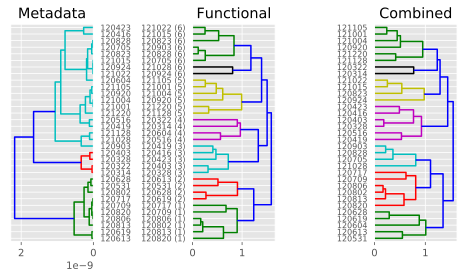

In [66]:
paired_dendrograms(mg_metadata_stand, mg_select_transm_stand, mg_combined, method="complete", metric="correlation", wspace=1.2,t=1.2)
plt.savefig("results/figures/mg_sample_clusters.png", bbox_inches="tight", dpi=300)

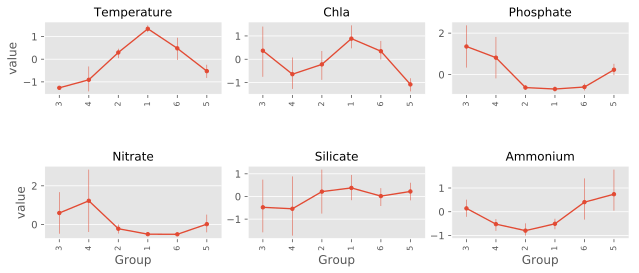

In [75]:
order = [3,4,2,1,6,5]
g = plot_env_groupings(mg_select_transm_stand, mg_metadata_stand, metric="correlation", method="complete", threshold=1.2, order=order)

The functional groupings indicates that the samples cluster into:

- one 'bloom' group (group 3)
- one 'pre/post-bloom' (group 4)
- one 'early-summer' group (group 2)
- one 'summer' group (group 1)
- one 'fall' group (group 6) (excluding the outliers 120924 and 121028)
- one 'winter' group (group 5)

In [57]:
mg_man = {}
mg_group_names = {3:"spring-bloom",4:"pre/post-bloom",2:"early-summer",1:"summer",6:"fall",5:"winter"}

for sample,group in g.items():
    if sample in ["120924","121028"]:
        continue
    try: 
        mg_man[sample] = mg_group_names[group]
    except KeyError: 
        continue

Plot the environmental data for the defined sample groups.

In [59]:
mg_group_env = mg_metadata.loc[mg_man.keys()]
mg_group_env["Sample"] = mg_group_env.index
mg_group_env["Group"] = [mg_man[x] for x in mg_group_env["Sample"]]

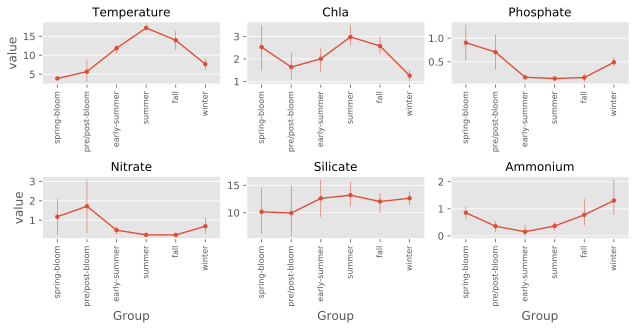

In [67]:
mg_group_env = mg_metadata.loc[mg_man.keys()]
mg_group_env["Sample"] = mg_group_env.index
mg_group_env["Group"] = [mg_man[x] for x in mg_group_env["Sample"]]
mg_group_env = pd.melt(mg_group_env,id_vars=["Sample","Group"])
ax = sns.factorplot(data=mg_group_env, col="variable", col_wrap=3, x="Group", 
                    order=["spring-bloom","pre/post-bloom","early-summer","summer","fall","winter"],
                    y="value",errwidth=0.5,sharey=False,sharex=False,scale=0.5, size=2, aspect=1.5)
ax.set_titles("{col_name}");
for a in ax.axes: a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8);
ax.fig.subplots_adjust(wspace=.15, hspace=1.5)
plt.savefig("results/figures/mg_sample_clusters_metadata.png", bbox_inches="tight", dpi=300)

Re-plot dendrogram with groupings.

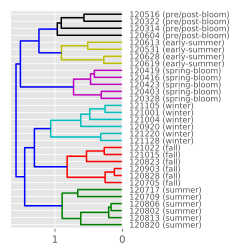

In [68]:
mg_grouped_stand = standardize(mg_select_trans.groupby(level=0).sum().T.loc[mg_man.keys()])
mg_grouped_stand.rename(index=lambda x: "{} ({})".format(x,mg_man[x]),inplace=True)
d = pdist(mg_grouped_stand,metric="correlation")
Z = linkage(d,method="complete")
plt.figure(figsize=(2,4))
ax = dendrogram(Z,orientation="left",labels=mg_grouped_stand.index, color_threshold=1.2)
plt.savefig("results/figures/mg_sample_clusters_groups.png",dpi=300, bbox_inches="tight")

Write sample groups to file.

In [69]:
(pd.DataFrame(mg_man,index=["Group"]).T).to_csv("results/mg/samplegroups.tab", sep="\t")

### Metatranscriptomes

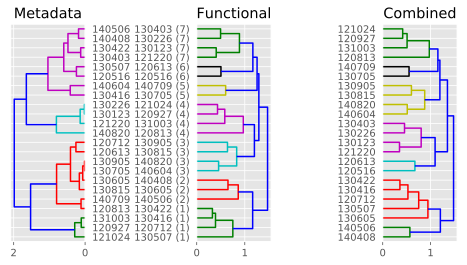

In [82]:
paired_dendrograms(mt_metadata_stand, mt_select_transm_stand, mt_combined, method="complete", metric="correlation", wspace=1.5,t=1)
plt.savefig("results/figures/mt_sample_clusters.png", bbox_inches="tight", dpi=300)

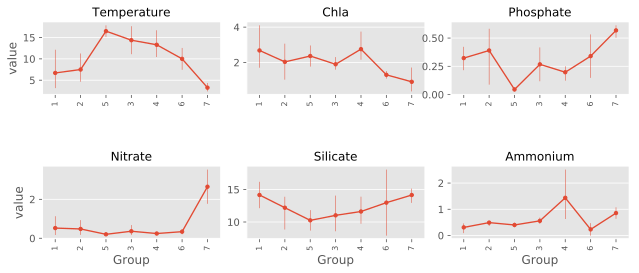

In [83]:
order = [1,2,5,3,4,6,7]
g = plot_env_groupings(mt_select_transm_stand,mt_metadata,metric="correlation",method="complete",threshold=1, order=order)

The clustering of the metatranscriptomic samples does not follow a seasonal pattern to the same degree as the metagenomic data, probably because of sparser sampling over multiple years. However, the functional clustering seems to indicate:

- one 'spring/early-summer' group (merge groups 1 and 2)
- one 'summer' group (group 3)
- one 'fall' group (group 4, **move 130905 into this group**)
- one 'winter' group (group 7)

In addition, there are small clusters that appear separate from the rest:
- one 'july' group from two consecutive years (130705 and 140709)
- one 'early-summer' group from 2012 (120516 and 120613)

In [97]:
mt_man = {}
mt_group_names = {1:"spring/early-summer",2:"spring/early-summer",3:"summer",4:"fall",7:"winter"}

for sample,group in g.items():
    if sample == "130905": group = "fall"
    try: 
        mt_man[sample] = mt_group_names[group]
    except KeyError: continue

**The metatranscriptome time-series seems to have two sample groups from early-summer samples.**

Plot the environmental data for defined groups.

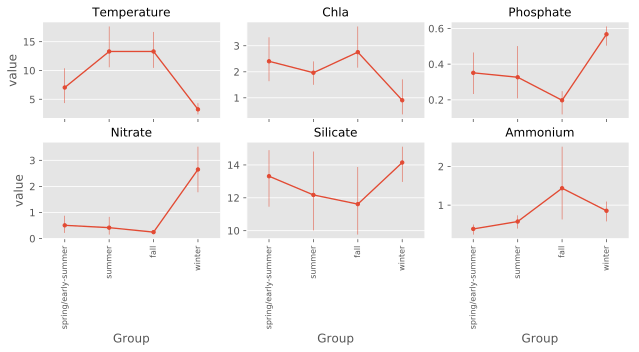

In [98]:
mt_group_env = mt_metadata.loc[mt_man.keys()]
mt_group_env["Sample"] = mt_group_env.index
mt_group_env["Group"] = [mt_man[x] for x in mt_group_env["Sample"]]
mt_group_env = pd.melt(mt_group_env,id_vars=["Sample","Group"])
ax = sns.factorplot(data=mt_group_env, col="variable", col_wrap=3, x="Group", y="value",errwidth=0.5,
                    sharey=False,sharex=True,scale=0.5, size=2, aspect=1.5, 
                    order=["spring/early-summer","summer","fall","winter"])
ax.set_xticklabels(rotation=90,fontsize=6);
ax.set_titles("{col_name}",fontsize=10);
for a in ax.axes: a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8);
ax.fig.subplots_adjust(wspace=.15, hspace=0.25)
plt.savefig("results/figures/mt_sample_clusters_metadata.png", dpi=300, bbox_inches="tight")

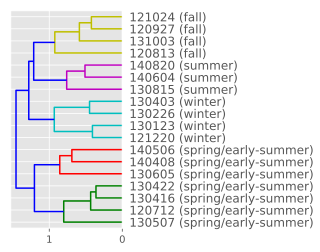

In [99]:
mt_grouped_stand = standardize(mt_select_trans.groupby(level=0).sum().T.loc[mt_man.keys()])
mt_grouped_stand.rename(index=lambda x: "{} ({})".format(x,mt_man[x]),inplace=True)
d = pdist(mt_grouped_stand,metric="correlation")
Z = linkage(d,method="complete")
plt.figure(figsize=(2,4))
ax = dendrogram(Z,orientation="left",labels=mt_grouped_stand.index, color_threshold=1.2)
plt.savefig("results/figures/mt_sample_clusters_groups.png",dpi=300, bbox_inches="tight")

In [100]:
(pd.DataFrame(mt_man,index=["Group"]).T).to_csv("results/mt/samplegroups.tab",sep="\t")